# Split the data

In [1]:
from torch_geometric.loader import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
import torch
from collections import Counter
import sys
sys.path.append("../src")
from reachability_model_holds_features_function import ReachabilityFeaturesGNN
from torch_geometric.data import Batch
from reachability_model_holds_features_function import plot_graph_prediction
from reachability_model_holds_features_function import FocalLoss

In [2]:
# Load the Graphs
data = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_17820\1844560907.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../data/graph_list_holds_features.pt")


In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Option 1: Calculate the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [5]:
weights

tensor([0.0766, 3.2582, 3.3765, 5.0000], device='cuda:0')

# Option 2: Use Balanced to calcualte the weights

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.cpu().numpy())  

classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)

weights = np.clip(weights, a_min=None, a_max=5.0)
weights = torch.tensor(weights, dtype=torch.float).to(device)

In [6]:
weights

tensor([0.2699, 5.0000, 5.0000, 5.0000], device='cuda:0')

# Train the Model

In [13]:
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityFeaturesGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# CrossEntropyLoss
# loss_fn = CrossEntropyLoss(weight=weights)

# FocalLoss
loss_fn = FocalLoss(gamma=1.0, weight=weights)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 1360.2107
Epoch 2: Loss = 1051.1511
Epoch 3: Loss = 962.4131
Epoch 4: Loss = 916.6967
Epoch 5: Loss = 882.6131
Epoch 6: Loss = 856.7044
Epoch 7: Loss = 834.5564
Epoch 8: Loss = 817.6827
Epoch 9: Loss = 799.8355
Epoch 10: Loss = 786.9407
Epoch 11: Loss = 778.5045
Epoch 12: Loss = 761.0716
Epoch 13: Loss = 758.0354
Epoch 14: Loss = 743.5800
Epoch 15: Loss = 731.0846
Epoch 16: Loss = 726.3725
Epoch 17: Loss = 719.0739
Epoch 18: Loss = 709.3252
Epoch 19: Loss = 701.7983
Epoch 20: Loss = 698.3441
Epoch 21: Loss = 694.1642
Epoch 22: Loss = 687.8634
Epoch 23: Loss = 686.8439
Epoch 24: Loss = 677.7893
Epoch 25: Loss = 676.9900
Epoch 26: Loss = 682.8577
Epoch 27: Loss = 669.7377
Epoch 28: Loss = 664.4149
Epoch 29: Loss = 662.4066
Epoch 30: Loss = 656.0748
Epoch 31: Loss = 653.0313
Epoch 32: Loss = 656.9667
Epoch 33: Loss = 662.1348
Epoch 34: Loss = 644.2958
Epoch 35: Loss = 643.9532
Epoch 36: Loss = 640.3556
Epoch 37: Loss = 635.2308
Epoch 38: Loss = 631.5970
Epoch 39: Loss = 63

In [14]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device) 
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 975536, 1: 176121, 2: 171066, 3: 1356})


In [15]:
torch.save(model.state_dict(),"reachability_features_model4.pt")

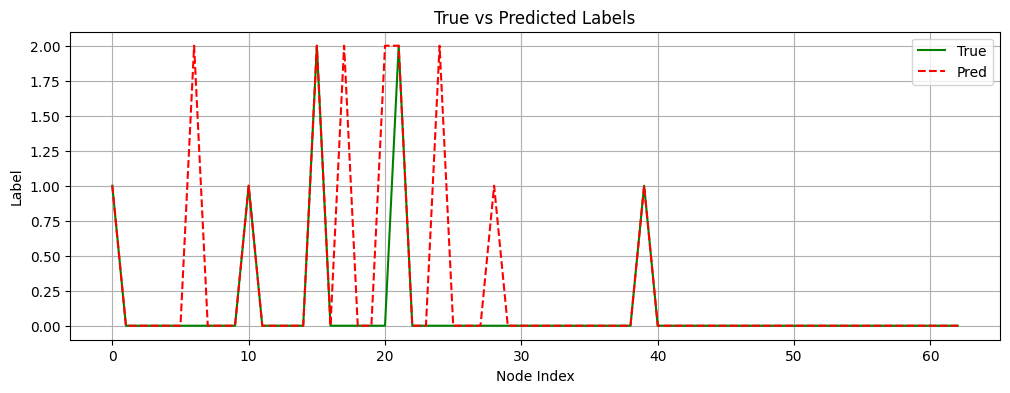

In [16]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       1.00      0.79      0.88    302683
        hand       0.25      0.87      0.39     12683
        foot       0.23      0.88      0.37     11289
        both       0.96      0.88      0.92       363

    accuracy                           0.80    327018
   macro avg       0.61      0.85      0.64    327018
weighted avg       0.94      0.80      0.85    327018



# Load already had model to check the performance

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReachabilityFeaturesGNN().to(device)
model.load_state_dict(torch.load("reachability_features_model.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_34120\4062656412.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_features_mode

ReachabilityFeaturesGNN(
  (conv1): GCNConv(6, 64)
  (norm1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (norm2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (climber_embed): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [3]:
graph_list = torch.load("../data/graph_list_holds_features.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_34120\2271411771.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("../data/graph_list_holds_features.p

In [4]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

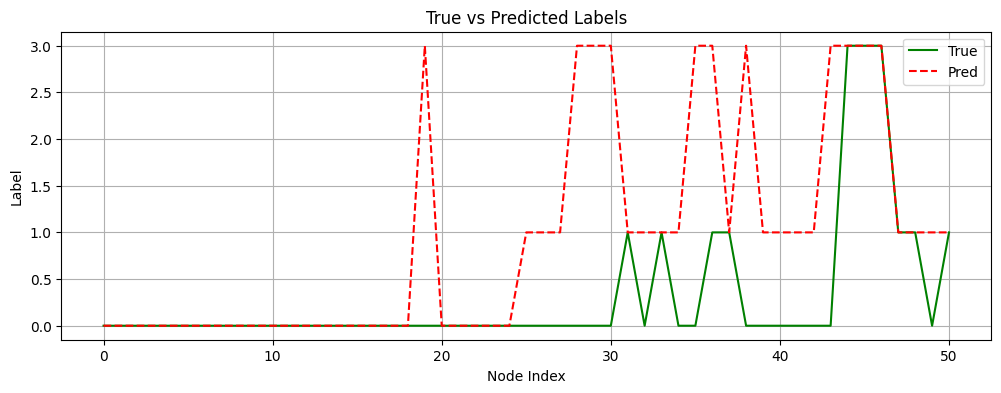

In [17]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[2450]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import classification_report

all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 unreachable       0.93      0.46      0.61   1376661
        hand       0.21      0.60      0.31    221572
        foot       0.00      0.00      0.00      2442
        both       0.18      0.52      0.27    155498

    accuracy                           0.48   1756173
   macro avg       0.33      0.39      0.30   1756173
weighted avg       0.77      0.48      0.54   1756173



c:\Users\guanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


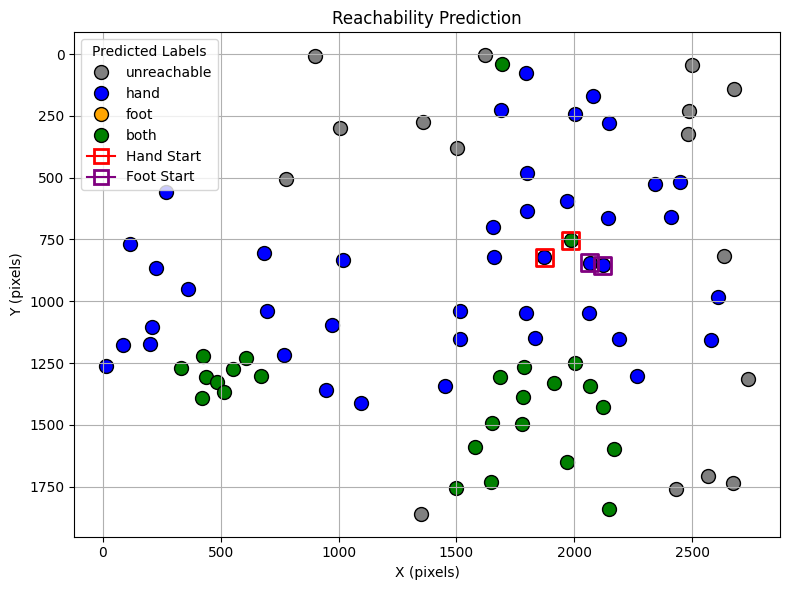

In [6]:
graph = test_data[0]
batch = Batch.from_data_list([graph])
plot_graph_prediction(batch, model, "Reachability Prediction")